Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        6.1e+05 s    Elapsed time so far: 24.0 s


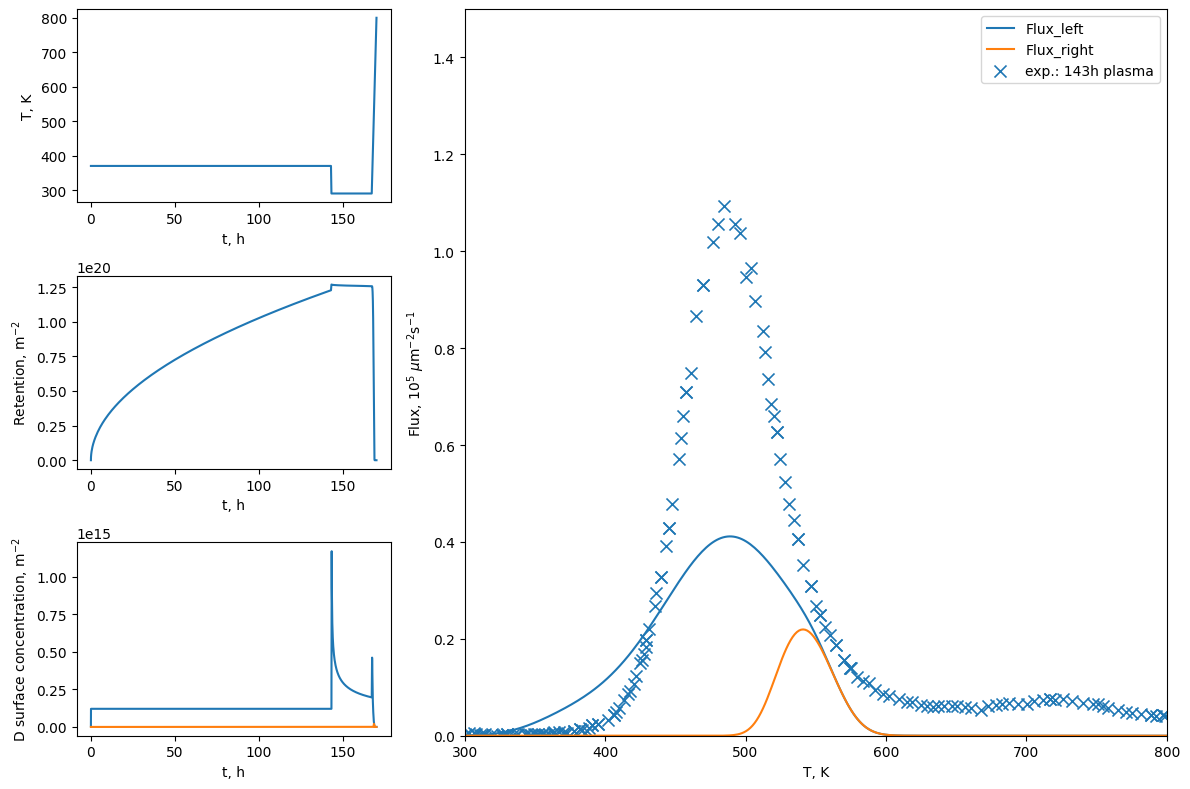

In [1]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import warnings
from scipy import special

warnings.filterwarnings("ignore")

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19
M_D2 = 4.028e-3 / N_A_const  # the D2 mass, kg mol^-1

# Exposure conditions
P_D2 = 1  # Pa
T_load = 370  # D loading temperature, K
T_storage = 290  # temperature after colling phase, K
ramp = 3 / 60  # TDS heatin rate, K/s
t_load = 143 * 3600  # exposure duration, s
t_cool = 1000  # colling duration, s
t_storage = 24 * 3600  # storage time, s
t_TDS = (800 - T_storage) / ramp  # TDS duration (up to 800 K), s
cooling_rate = (T_load - T_storage) / t_cool  # cooling rate, K/s


# Sample
L = 0.8e-3  # half thickness, m
A = 12e-3 * 15e-3  # surface area, m^2

# EUROFER properties
rho_EFe = 8.48e28  # EUROFER atomic concentration, m^-3
n_IS = rho_EFe  # concentration of interstitial sites, m^-3
n_surf = rho_EFe ** (2 / 3)  # concentration of adsorption sites, m^-2
lambda_lat = rho_EFe ** (-1 / 3)  # Typical lattice spacing, m

D0 = 1.5e-7  # diffusivity pre-factor, m^2 s^-1
E_diff = 0.15  # diffusion activation energy, eV

# Energy landscape
E_bs = E_diff  # energy barrier from bulk to surface transition, eV
nu_bs = D0 / lambda_lat**2  # attempt frequency for b-to-s transition, s^-1
E_diss = 0.4  # energy barrier for D2 dissociation, eV
E_rec = 0.7  # energy barrier for D2 recombination, eV
E_sol = 0.238  # heat of solution, eV
S0 = 1.5e-6
Xi0 = 1e-4
chi0 = 1e-4
# E_sb = E_rec/2 - 5_diss/2 + 0.238 + E_diff  # energy barrier from bulk to surface transition, eV

# Trap properties
nu_tr = 8.9e12  # trapping attempt frequency, s^-1
nu_dt = 2.0e13  # trapping attempt frequency, s^-1
E_tr = E_diff
E_dt_intr = 0.9  # detrapping energy for intrinsic traps, eV
E_dt_dpa = 1.1  # detrapping energy for DPA traps, eV

# Implantation parameters
Gamma = 9e19  # irradiation flux, m^-2 s^-1
R = 4.09e-10  # implantation range, m
# sigma = 2.35e-10 # standart deviation, m
sigma = 1 / np.sqrt(2 * 6.25e6) * 1e-6
r = 0.5  # reflection coefficient


################### FUNCTIONS ###################
def Xi(T):
    # unitless
    return Xi0 * f.exp(-E_diss / F.k_B / T)


def chi(T):
    # in m^2 s^-1
    return chi0 * f.exp(-E_rec / F.k_B / T)


def S(T):
    # solubility
    return S0 * f.exp(-E_sol / F.k_B / T)


def Psi(T):
    return 1 / f.sqrt(2 * np.pi * M_D2 * F.k_B * T * e)


def J_vs(T, surf_conc, t):
    J_diss = (
        2 * P_D2 * Xi(T) * (1 - surf_conc / n_surf) ** 2 * Psi(T)
    )  # dissociation flux

    J_rec = 2 * chi(T) * surf_conc**2  # recombination flux

    Omega_loss = 8e4
    J_loss = (surf_conc / n_surf) * Omega_loss * Gamma  # ad hoc flux for fit

    J_net = f.conditional(t <= t_load + t_cool, J_diss - J_loss, 0) - J_rec
    return J_net


def k_bs(T, surf_conc, t):
    return nu_bs * f.exp(-E_bs / F.k_B / T)


def k_sb(T, surf_conc, t):
    # see eqs. (13-14) in K. Schmid and M. Zibrov 2021 Nucl. Fusion 61 086008
    return k_bs(T, surf_conc, t) * S(T) * n_surf * f.sqrt(chi(T) / Psi(T) / Xi(T))


def norm_flux(X, sigma):
    return 2 / (
        special.erf((0.8e-3 - X) / np.sqrt(2) / sigma)
        + special.erf((X) / np.sqrt(2) / sigma)
    )


################### MODEL ###################

EFe_model = F.Simulation(log_level=40)

# Mesh
vertices = np.concatenate(
    [
        np.linspace(0, 2e-8, num=101),
        np.linspace(1e-8, 5e-6, num=250),
        np.linspace(5e-6, L, num=500),
    ]
)

EFe_model.mesh = F.MeshFromVertices(np.sort(vertices))

# Materials
EFe = F.Material(id=1, D_0=D0, E_D=E_diff)
EFe_model.materials = EFe

surf_conc1 = F.SurfaceKinetics(
    k_sb=k_sb,
    k_bs=k_bs,
    lambda_IS=lambda_lat,
    n_surf=n_surf,
    n_IS=n_IS,
    J_vs=J_vs,
    surfaces=[1, 2],
    initial_condition=0,
    t=F.t,
)

EFe_model.boundary_conditions = [surf_conc1]

traps = F.Traps(
    [
        F.Trap(
            k_0=nu_tr / n_IS,
            E_k=E_tr,
            p_0=nu_dt,
            E_p=E_dt_intr,
            density=1e-5 * rho_EFe,
            materials=EFe,
        ),
        # F.Trap(
        #   k_0=nu_tr / n_IS,
        #   E_k=E_tr,
        #   p_0=nu_dt,
        #   E_p=E_dt_dpa,
        # density=sp.Piecewise((0.25e-3 * rho_EFe, F.x <= 3e-6), (0, True)),
        #   density=0.25e-3 * rho_EFe * (1/(1 + sp.exp((F.x-3e-6)*5e6))),
        #   materials=EFe,
        # ),
    ]
)
EFe_model.traps = traps
# EFe_model.initial_conditions = [F.InitialCondition(field="1", value=1e-5*rho_EFe)]

EFe_model.sources = [
    F.ImplantationFlux(
        flux=sp.Piecewise(
            (Gamma * (1 - r) * norm_flux(R, sigma), F.t <= t_load + t_cool), (0, True)
        ),
        imp_depth=R,
        width=sigma,
        volume=1,
    )
]


EFe_model.T = F.Temperature(
    value=sp.Piecewise(
        (T_load, F.t <= t_load),
        (T_load - cooling_rate * (F.t - t_load), F.t <= t_load + t_cool),
        (T_storage, F.t <= t_load + t_cool + t_storage),
        (T_storage + ramp * (F.t - t_load - t_cool - t_storage), True),
    )
)


def step_size(t):
    if t <= t_load:
        return 2.5e3
    elif t > t_load and t <= t_load + t_cool + t_storage:
        return 0.5e3
    else:
        return 30


EFe_model.dt = F.Stepsize(
    initial_value=1e-7,
    stepsize_change_ratio=1.5,
    max_stepsize=step_size,
    dt_min=1e-7,
    milestones=[
        t_load,
        t_load + t_cool,
        t_load + t_cool + t_storage,
    ],
)

EFe_model.settings = F.Settings(
    absolute_tolerance=1e12,
    relative_tolerance=1e-10,
    maximum_iterations=50,
    final_time=t_load + t_cool + t_storage + t_TDS,
)

# Exports
results_folder = "./results/"
"""
XDMF = [
    F.XDMFExport(
        field="solute",
        filename=results_folder + "/mobile.xdmf",
        checkpoint=False,  # needed in 1D
        mode=10,
    ),
    F.XDMFExport(
        field="1",
        filename=results_folder + "/trapped1.xdmf",
        checkpoint=False,  # needed in 1D
        mode=10,
    ),
    F.XDMFExport(
        field="retention",
        filename=results_folder + "/ret.xdmf",
        checkpoint=False,  # needed in 1D
        mode=10,
    ),
    F.XDMFExport(
        field="T",
        filename=results_folder + "/T.xdmf",
        checkpoint=False,  # needed in 1D
        mode=10,
    ),
]"""

derived_quantities = [
    F.DerivedQuantities(
        [
            F.AdsorbedHydrogen(surface=1),
            F.AdsorbedHydrogen(surface=2),
            F.TotalSurface(field="T", surface=1),
            F.AverageVolume(field="T", volume=1),
            F.TotalVolume(field="retention", volume=1),
            F.HydrogenFlux(surface=1),
            F.PointValue(field="1", x=0),
            F.HydrogenFlux(surface=2),
        ],
        nb_iterations_between_compute=1,
        filename=results_folder + "test.csv",
    )
]

EFe_model.exports = derived_quantities

EFe_model.initialise()
EFe_model.run()

results = pd.read_csv(results_folder + "test.csv", header=0)

results["Flux1"] = results["Adsorbed H on surface 1"]
results["Flux2"] = results["Adsorbed H on surface 1"]
for j in range(len(results)):
    surf_conc1 = results["Adsorbed H on surface 1"][j]
    surf_conc2 = results["Adsorbed H on surface 2"][j]
    T = results["Total T surface 1"][j]

    results["Flux1"][j] = 2 * surf_conc1**2 * chi0 * np.exp(-E_rec / F.k_B / T)
    results["Flux2"][j] = 2 * surf_conc2**2 * chi0 * np.exp(-E_rec / F.k_B / T)

exp = pd.read_csv(f"./exp_data/143hplasma_new.csv", header=None, skiprows=1, sep=",")


fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[:, 1:])

ax4.plot(
    T_storage + (results["t(s)"] - t_load - t_cool - t_storage) * ramp,
    (results["Flux1"] / 1e12 / 1e5),
    label="Flux_left",
)
# ax3.plot(T_storage + (results["t(s)"]-t_load-t_cool-t_storage)*ramp, (-results["Flux surface 1: solute"]/1e12), ls='dashed')
ax4.plot(
    T_storage + (results["t(s)"] - t_load - t_cool - t_storage) * ramp,
    (results["Flux2"] / 1e12 / 1e5),
    label="Flux_right",
)
"""ax4.plot(
    T_storage + (results["t(s)"] - t_load - t_cool - t_storage) * ramp,
    ((results["Flux2"] + results["Flux1"]) / 1e12 / 1e5),
    label="Total",
)"""

ax4.scatter(
    exp[0], exp[1] / 1e5, marker="x", s=75, linewidths=1.2, label="exp.: 143h plasma"
)
ax4.legend()

ax4.set_xlim(300, 800)
ax4.set_ylim(0, 1.5)
# ax4.set_yscale('log')
ax4.set_xlabel("T, K")
ax4.set_ylabel(r"Flux, $10^5$ $\mu$m$^{-2}$s$^{-1}$")

# acx = ax3.twinx()
# acx.plot(T_storage + (results["t(s)"]-t_load-t_cool-t_storage)*ramp, results["Concentration of adsorbed H on surface 1"]/n_surf, color = 'tab:red')
# acx.plot(T_storage + (results["t(s)"]-t_load-t_cool-t_storage)*ramp, results["solute value at [0]"]/n_IS, color = 'tab:green')
# ax1.plot(T_storage + (results["t(s)"]-t_load-t_cool-t_storage)*ramp, results["Concentration of adsorbed H on surface 2"])
# plt.plot(results["t(s)"], results["Concentration of adsorbed H on surface 2"]/n_surf)
# acx.set_xlim(300, 800)
# ax1.set_xscale('log')
ax1.plot(results["t(s)"] / 3600, results["Total T surface 1"])
ax1.set_ylabel("T, K")
ax1.set_xlabel("t, h")

ax2.plot(results["t(s)"] / 3600, results["Total retention volume 1"])
ax2.set_ylabel(r"Retention, m$^{-2}$")
ax2.set_xlabel("t, h")

ax3.plot((results["t(s)"] / 3600), results["Adsorbed H on surface 1"])
ax3.plot((results["t(s)"] / 3600), results["Adsorbed H on surface 2"])
ax3.set_ylabel(r"D surface concentration, m$^{-2}$")
ax3.set_xlabel("t, h")

plt.tight_layout()
plt.show()